# QRT ENS Data Challenge 2023 - Benchmark (english)

This notebook details the benchmark construction for the challenge - it may also help participants to start the competition.

## Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [3]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('x_train.csv')
df = pd.read_csv('x_train.csv')
Y_train = pd.read_csv('y_train.csv')
df['TARGET'] = Y_train['TARGET']
X_test = pd.read_csv('x_test.csv')
etypes = ['GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW', 'LIGNITE']

In [4]:
df.columns

Index(['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'TARGET'],
      dtype='object')

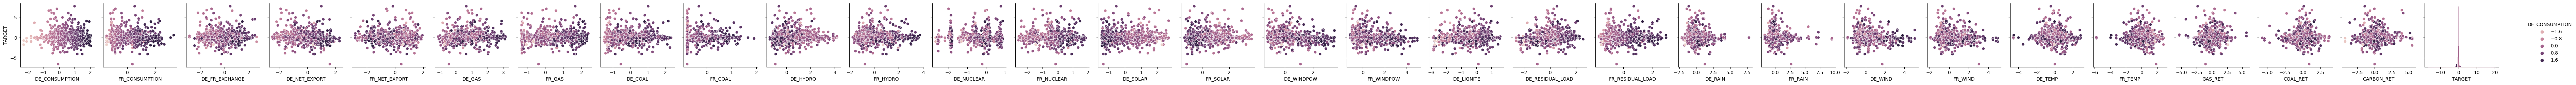

In [5]:
sns.pairplot(data=df, x_vars = ['DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET', 'TARGET'], y_vars = 'TARGET',hue='DE_CONSUMPTION')

In [28]:
sns.pairplot(data=df, x_vars = ['DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'], y_vars = 'TARGET',hue='DE_SOLAR')

In [29]:
sns.pairplot(data=df, vars = ['DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET', 'TARGET'], hue='COUNTRY')

In [32]:
df_corrs = df[['DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET', 'TARGET']].corr()
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(df_corrs, annot=True, annot_kws={"fontsize":7})

<Axes: >

In [12]:
X_train.describe()

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
count,1494.000000,1494.000000,1494.000000,1494.000000,1469.000000,1469.000000,1370.000000,1424.000000,1370.000000,1424.000000,...,1494.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1494.000000,1494.000000,1494.000000
mean,1072.759036,591.861446,0.427442,-0.020032,-0.145508,0.145508,-0.256332,-0.072643,0.256332,0.072643,...,-0.153688,-0.037831,0.019357,0.109480,0.123099,0.009451,0.008404,0.058126,0.061724,0.080510
std,618.013179,345.065043,0.673412,0.918995,0.970226,0.970226,0.957443,1.075830,0.957443,1.075830,...,0.896325,0.984233,1.051781,1.056243,1.054692,0.972394,1.003356,1.097768,1.033853,1.098624
min,0.000000,0.000000,-2.265563,-1.462350,-2.856874,-2.634831,-2.464849,-2.825331,-2.279619,-1.951516,...,-1.678936,-2.128531,-1.726420,-1.880419,-1.895319,-4.549638,-5.787097,-5.349463,-5.706442,-4.281790
25%,540.250000,292.250000,-0.037421,-0.716771,-0.875213,-0.638867,-0.977214,-0.851500,-0.452252,-0.794843,...,-0.802333,-0.642117,-0.503927,-0.652135,-0.672614,-0.618259,-0.647948,-0.624238,-0.458038,-0.522968
50%,1077.500000,591.000000,0.357061,-0.394166,-0.164287,0.164287,-0.306899,0.099455,0.306899,-0.099455,...,-0.460160,-0.274901,-0.228147,-0.261571,-0.229031,-0.026306,-0.020889,0.008493,0.063312,0.054056
75%,1597.500000,885.750000,0.922057,0.650533,0.638867,0.875213,0.452252,0.794843,0.977214,0.851500,...,0.382191,0.335237,0.154351,0.635050,0.824781,0.651832,0.699131,0.676415,0.641446,0.599094
max,2146.000000,1215.000000,2.033851,3.300640,2.634831,2.856874,2.279619,1.951516,2.464849,2.825331,...,2.918326,7.756118,9.473201,5.085624,4.965028,2.858758,2.817239,5.674778,3.746576,5.471818


In [13]:
X_train.isna().sum()

ID                    0
DAY_ID                0
COUNTRY               0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       25
FR_DE_EXCHANGE       25
DE_NET_EXPORT       124
FR_NET_EXPORT        70
DE_NET_IMPORT       124
FR_NET_IMPORT        70
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN              94
FR_RAIN              94
DE_WIND              94
FR_WIND              94
DE_TEMP              94
FR_TEMP              94
GAS_RET               0
COAL_RET              0
CARBON_RET            0
dtype: int64

In [19]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [20]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Model and train score

The benchark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

In [31]:
lr = LinearRegression()

X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

lr.fit(X_train_clean, Y_train_clean)

output_train = lr.predict(X_train_clean)

def metric_train(output):

    return  spearmanr(output, Y_train_clean).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train) ))

Spearman correlation for the train set: 27.9%


The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

## Generate the benchmark output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


In [22]:
X_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


In [23]:
X_test_clean = X_test.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = lr.predict(X_test_clean)

Y_test_submission.to_csv('benchmark_qrt.csv', index=False)


After submitting this benchmark_qrt.csv file at https://challengedata.ens.fr, we obtain a public score of around 15.9 % - this is the score to beat!


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 
